In [94]:
using PyCall
using MXNet
using MLDataPattern
using Polyhedra
using CDDLib
using Plots
plotly()

Plots.PlotlyBackend()

In [2]:
push!(pyimport("sys")["path"], joinpath(pwd(), "py-mpc"));

In [3]:
@pyimport pympc.geometry as geometry
@pyimport pympc.control as control
@pyimport pympc.dynamical_systems as dynamical_systems
@pyimport pympc.plot as mpcplot
@pyimport scipy.spatial as spatial

In [4]:
include("mpc.jl")

MPC

In [5]:
mass = 1.
l = 1.
g = 10.
N = 4
# A = [0. 1.;
#      g/l 0.]
# B = [0 1/(mass*l^2.)]'
A = [0. 1; 0 0]
B = [0. 1]'
Δt = .1
pysys = dynamical_systems.DTLinearSystem[:from_continuous](A, B, Δt)

# x_max = [pi/6, pi/20/(N*Δt)]
x_max = [1., 1]
x_min = -x_max
# u_max = [mass*g*l*pi/8.]
u_max = [1.]
u_min = -u_max
times = 0:Δt:N*Δt

Q = 10 * eye(2)
R = eye(1)

X_bounds = geometry.Polytope[:from_bounds](reshape(x_min, 2, 1), reshape(x_max, 2, 1))[:assemble]()
U_bounds = geometry.Polytope[:from_bounds](reshape(u_min, 1, 1), reshape(u_max, 1, 1))[:assemble]()
controller = control.MPCController(pysys, N, "two", Q, R, X=X_bounds, U=U_bounds)

PyObject <pympc.control.MPCController instance at 0x31c9e9908>

In [6]:
controller[:get_explicit_solution]()

Computing critical region for the active set []
Computing critical region for the active set [0]
Computing critical region for the active set [1]
Computing critical region for the active set [2]
Computing critical region for the active set [4]
Computing critical region for the active set [8]
Computing critical region for the active set [10]
Computing critical region for the active set [14]
Computing critical region for the active set [16]
Computing critical region for the active set [20]
Computing critical region for the active set [22]
LICQ does not hold for the active set [0, 2]
    unfeasible critical region detected
Computing critical region for the active set [0, 6]
Computing critical region for the active set [0, 22]
LICQ does not hold for the active set [1, 4]
    unfeasible critical region detected
Computing critical region for the active set [1, 7]
Computing critical region for the active set [1, 20]
LICQ does not hold for the active set [1, 2]
    unfeasible critical region d

/usr/local/lib/python2.7/site-packages/numpy/linalg/linalg.py:1502: RuntimeWarning: divide by zero encountered in true_divide
  return s[..., 0]/s[..., -1]


In [7]:
# mpcplot.state_partition(explicit_controller)
# mpcplot.plt[:show]()

# mpcplot.grouped_state_partition(explicit_controller)
# mpcplot.plt[:show]()

In [8]:
num_samples = 1000
X = fill(NaN, 2, num_samples)
U = fill(NaN, 1, num_samples)

for i in 1:num_samples
    while true
        x0 = x_min .+ rand(2) .* (x_max .- x_min)
        u_feedforward, cost = controller[:feedforward](x0)
        if !any(isnan.(u_feedforward[1]))
            X[:, i] = x0
            U[:, i] = u_feedforward[1]
            break
        end
    end
end

In [9]:
(X_train, U_train), (X_test, U_test) = splitobs((X, U), 0.6)
batch_size = 20
train_provider = mx.ArrayDataProvider(:x=>collect(X_train), :u_label=>collect(U_train), batch_size=batch_size)
test_provider = mx.ArrayDataProvider(:x=>collect(X_test), :u_label=>collect(U_test), batch_size=batch_size)

MXNet.mx.ArrayDataProvider(Array[
Float32[-0.329427 0.0371791 … 0.490333 -0.814951; 0.847086 0.973222 … -0.475129 -0.538475]],Symbol[:x],Array[
Float32[-1.0 -1.0 … 0.915735 1.0]],Symbol[:u_label],20,400,false,0.0f0,0.0f0,MXNet.mx.NDArray[mx.NDArray{Float32}(2,20)],MXNet.mx.NDArray[mx.NDArray{Float32}(1,20)])

In [10]:
mlp = @mx.chain mx.Variable(:x) => 
mx.FullyConnected(name=:fc1, num_hidden=4) =>
mx.LeakyReLU(name=:relu1, act_type=:leaky, slope=0.1) =>
mx.FullyConnected(name=:fc2, num_hidden=4) =>
mx.LeakyReLU(name=:relu2, act_type=:leaky, slope=0.1) => 
mx.FullyConnected(name=:fc3, num_hidden=4) => 
mx.LeakyReLU(name=:relu3, act_type=:leaky, slope=0.1) =>
mx.FullyConnected(name=:fc4, num_hidden=1) =>
mx.LinearRegressionOutput(name=:u)

# mlp = @mx.chain mx.Variable(:x) => 
# mx.FullyConnected(name=:fc1, num_hidden=1) =>|
# mx.Activation(name=:relu1, act_type=:relu) =>
# mx.FullyConnected(name=:fc2, num_hidden=1) =>
# mx.LinearRegressionOutput(name=:u)

model = mx.FeedForward(mlp, context=mx.cpu())
# optimizer = mx.ADAM(lr=0.1)
optimizer = mx.SGD(lr=0.1, momentum=0.8)
mx.fit(model, optimizer, train_provider, n_epoch=10, verbosity=2, initializer=mx.UniformInitializer(1.0))

U_predict = mx.predict(model, test_provider)
err = U_predict .- U_test
sqrt(mean(err.^2))

INFO: Start training on MXNet.mx.Context[CPU0]
INFO: Initializing parameters...
INFO: Creating KVStore...
INFO: TempSpace: Total 0 MB allocated on CPU0
INFO: Start training...
INFO: == Epoch 001/010 ==========
INFO: == Epoch 002/010 ==========
INFO: == Epoch 003/010 ==========
INFO: == Epoch 004/010 ==========
INFO: == Epoch 005/010 ==========
INFO: == Epoch 006/010 ==========
INFO: == Epoch 007/010 ==========
INFO: == Epoch 008/010 ==========
INFO: == Epoch 009/010 ==========
INFO: == Epoch 010/010 ==========
INFO: Finish training on MXNet.mx.Context[CPU0]
INFO: TempSpace: Total 0 MB allocated on CPU0


0.028819316062462602

In [11]:
include("explicit_network.jl")

ExNet

In [12]:
net = ExNet.Net([
    Array{Float64}(model.arg_params[:fc1_weight]),
    Array{Float64}(model.arg_params[:fc2_weight]),
    Array{Float64}(model.arg_params[:fc3_weight]),
    Array{Float64}(model.arg_params[:fc4_weight]),
    ],
[
    Array{Float64}(model.arg_params[:fc1_bias]),
    Array{Float64}(model.arg_params[:fc2_bias]),
    Array{Float64}(model.arg_params[:fc3_bias]),
    Array{Float64}(model.arg_params[:fc4_bias]),
])

ExNet.remove_small_weights!(net)

for i in 1:100
    x = randn(2)
    p = mx.predict(model, mx.ArrayDataProvider(:x=>reshape(x, 2, 1)), verbosity=0)[1]
    f = ExNet.feedforward(net, x)[end]
    if !(p ≈ f)
        @show p f
    end
    @assert p ≈ f
    
end

In [13]:
writedlm("weights.csv", vcat([vec(c') for c in net.coefficients]..., [vec(c) for c in net.biases]...))

In [14]:
bounds = hrep(polyhedron(SimpleVRepresentation([x_min[1] x_min[2]; x_min[1] x_max[2]; x_max[1] x_max[2]; x_max[1] x_min[2]]), CDDLibrary()))
results = ExNet.explore(net, bounds, [0.0, 0])

Dict{BitArray{1},Polyhedra.SimpleHRepresentation{2,Float64}} with 12 entries:
  Bool[false,false,false,t… => H-representation…
  Bool[false,false,true,tr… => H-representation…
  Bool[false,false,true,tr… => H-representation…
  Bool[false,false,false,f… => H-representation…
  Bool[false,false,true,tr… => H-representation…
  Bool[false,false,true,tr… => H-representation…
  Bool[false,true,true,tru… => H-representation…
  Bool[false,true,true,tru… => H-representation…
  Bool[false,true,true,tru… => H-representation…
  Bool[false,false,true,tr… => H-representation…
  Bool[false,true,true,tru… => H-representation…
  Bool[false,false,true,tr… => H-representation…

In [66]:
xx = linspace(x_min[1], x_max[1])
yy = linspace(x_min[2], x_max[2])
zz_exact = ((x, y) -> controller[:feedforward]([x, y])[1][1][1]).(xx', yy);
zz_learned = ((x, y) -> mx.predict(model, mx.ArrayDataProvider(:x=>[x y]'), verbosity=0)[1]).(xx', yy);

In [95]:
xx = linspace(x_min[1], x_max[1])
yy = linspace(x_min[2], x_max[2])
plt_learned = surface(xx, yy, zz_learned, 
legend=nothing,
xlabel="x1",
ylabel="x2",
zlabel="u",
    c=:redsblues
)
# nplot = 500
# plot!(plt, [X[1, i] for i in 1:nplot], [X[2, i] for i in 1:nplot], [U[1, i] for i in 1:nplot], markershape=:circle, markersize=3, line=nothing)
for (i, (state, p)) in enumerate(results)
    V = SimpleVRepresentation(vrep(polyhedron(p, CDDLibrary()))).V
    if !isempty(V)
        hull = spatial.ConvexHull(V)
        points = [hull[:points][i + 1, :] for i in hull[:vertices]]
        x = [p[1] for p in points]
        y = [p[2] for p in points]
        plot!(plt_learned, x, y, [ExNet.feedforward(net, [x[i], y[i]])[end] + 0.05 for i in eachindex(x)], linecolor=:white, linewidth=5)
    end
end
plt_learned

In [96]:
xx = linspace(x_min[1], x_max[1])
yy = linspace(x_min[2], x_max[2])
plt_exact = surface(xx, yy, zz_exact, 
legend=nothing,
xlabel="x₁",
ylabel="x₂",
zlabel="u",
   c=:redsblues
)
for (i, cr) in enumerate(controller[:critical_regions])
    polytope = cr[:polytope]
    V = hcat(polytope[:vertices]...)'
    if !isempty(V) && size(V, 1) > 2
        hull = spatial.ConvexHull(V)
        points = [hull[:points][i + 1, :] for i in hull[:vertices]]
        x = [p[1] for p in points]
        y = [p[2] for p in points]
        plot!(plt_exact, x, y, [controller[:feedforward]([x[i], y[i]])[1][1][1] + 0.05 for i in eachindex(x)], linecolor=:white, linewidth=5)
    end
end
plt_exact

In [18]:
mpcplot.grouped_state_partition(explicit_controller)
ax = mpcplot.plt[:gca]()
for (i, (state, p)) in enumerate(results)
    V = SimpleVRepresentation(vrep(polyhedron(p, CDDLibrary(:exact)))).V
    if !isempty(V)
        hull = spatial.ConvexHull(V)
        points = [hull[:points][i + 1, :] for i in hull[:vertices]]
        x = [p[1] for p in points]
        y = [p[2] for p in points]
       ax[:plot](x, y, "w-", linewidth=2)
    end
end
mpcplot.plt[:xlim]([x_min[1], x_max[1]])
mpcplot.plt[:ylim]([x_min[2], x_max[2]])
mpcplot.plt[:show]()
# mpcplot.plt[:savefig]("explicit.png")

Critical regions grouped in  15  sets.



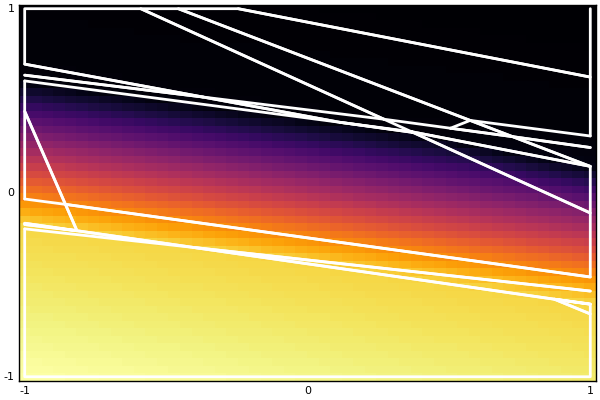

In [21]:
plt = heatmap(xx, yy, (x, y) -> mx.predict(model, mx.ArrayDataProvider(:x=>[x y]'), verbosity=0)[1],
    legend=nothing)
for (i, (state, p)) in enumerate(results)
    V = SimpleVRepresentation(vrep(polyhedron(p, CDDLibrary(:exact)))).V
    if !isempty(V)
        hull = spatial.ConvexHull(V)
        points = [hull[:points][i + 1, :] for i in hull[:vertices]]
        x = [p[1] for p in points]
        y = [p[2] for p in points]
        plot!(plt, x, y, linecolor=:white, linewidth=2)
    end
end
plt

In [19]:

mpcplot.plt[:savefig]("explicit.svg")